# Train a Neural ODE with Optax

We can use the parameter estimation functionality to fit a neural ODE to a time series data set.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from diffeqzoo import backend, ivps
from jax.config import config

from probdiffeq import ivpsolve, ivpsolvers, solution
from probdiffeq.doc_util import notebook
from probdiffeq.statespace import recipes
from probdiffeq.strategies import smoothers

In [2]:
plt.rcParams.update(notebook.plot_config())

if not backend.has_been_selected:
    backend.select("jax")  # ivp examples in jax

# Catch NaN gradients in CI
# Disable to improve speed
config.update("jax_debug_nans", True)

config.update("jax_platform_name", "cpu")

To keep the problem nice and small, assume that the data set is a trigonometric function (which solve differential equations).

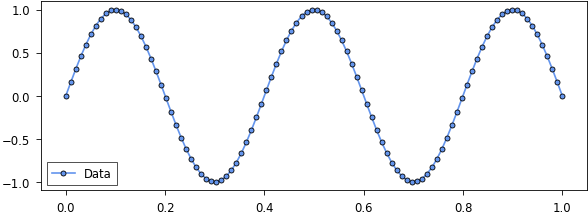

In [3]:
grid = jnp.linspace(0, 1, num=100)
data = jnp.sin(5 * jnp.pi * grid)

plt.plot(grid, data, ".-", label="Data")
plt.legend()
plt.show()

In [4]:
def build_loss_fn(vf, initial_values, obs_stdev=1e-2):
    """Build a loss function from an ODE problem."""

    @jax.jit
    def loss_fn(parameters):
        sol = ivpsolve.solve_fixed_grid(
            vf,
            initial_values=initial_values,
            grid=grid,
            solver=solver,
            parameters=parameters,
            output_scale=1.0,
        )

        observation_std = jnp.ones_like(grid) * obs_stdev
        return -1.0 * solution.log_marginal_likelihood(
            observation_std=observation_std, u=data[:, None], solution=sol
        )

    return loss_fn

In [5]:
def build_update_fn(*, optimizer, loss_fn):
    """Build a function for executing a single step in the optimization."""

    @jax.jit
    def update(params, opt_state):
        loss, grads = jax.value_and_grad(loss_fn)(params)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        return params, opt_state

    return update

## Construct an MLP with tanh activation

Let's start with the example given in the [implicit layers tutorial](http://implicit-layers-tutorial.org/neural_odes/). The vector field is provided by [DiffEqZoo](https://diffeqzoo.readthedocs.io/).

In [6]:
f, u0, (t0, t1), f_args = ivps.neural_ode_mlp(layer_sizes=(2, 20, 1))


@jax.jit
def vf(y, *, t, p):
    return f(y, t, *p)


# Make a solver
strategy = smoothers.Smoother(
    recipes.ts0_iso(num_derivatives=1),
)
solver = ivpsolvers.CalibrationFreeSolver(strategy)

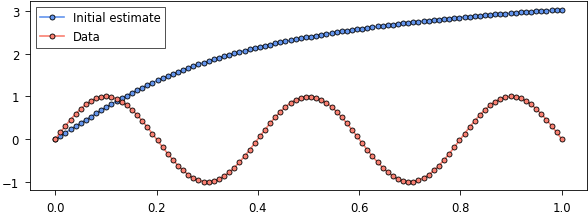

In [7]:
sol = ivpsolve.solve_fixed_grid(
    vf, initial_values=(u0,), grid=grid, solver=solver, parameters=f_args
)

plt.plot(sol.t, sol.u, ".-", label="Initial estimate")
plt.plot(grid, data, ".-", label="Data")
plt.legend()
plt.show()

## Set up a loss function and an optimiser

Like in the other tutorials, we use [Optax](https://optax.readthedocs.io/en/latest/index.html).

In [8]:
loss_fn = build_loss_fn(vf=vf, initial_values=(u0,))
optim = optax.adam(learning_rate=2e-2)
update_fn = build_update_fn(optimizer=optim, loss_fn=loss_fn)

In [9]:
p = f_args
state = optim.init(p)
chunk_size = 25
for i in range(chunk_size):
    for _ in range(chunk_size**2):
        p, state = update_fn(p, state)
    print(
        f"Neg. log-likelihood after {(i+1)*chunk_size**2}/{chunk_size**3} steps:",
        loss_fn(p),
    )

Neg. log-likelihood after 625/15625 steps: 1792.3065
Neg. log-likelihood after 1250/15625 steps: 1473.5238
Neg. log-likelihood after 1875/15625 steps: 1361.915
Neg. log-likelihood after 2500/15625 steps: 1290.0542
Neg. log-likelihood after 3125/15625 steps: 1078.135
Neg. log-likelihood after 3750/15625 steps: 894.33704
Neg. log-likelihood after 4375/15625 steps: 614.5224
Neg. log-likelihood after 5000/15625 steps: 299.1397
Neg. log-likelihood after 5625/15625 steps: 122.475716
Neg. log-likelihood after 6250/15625 steps: 72.957886
Neg. log-likelihood after 6875/15625 steps: 67.81621
Neg. log-likelihood after 7500/15625 steps: 52.892315
Neg. log-likelihood after 8125/15625 steps: 40.913475
Neg. log-likelihood after 8750/15625 steps: 29.583172
Neg. log-likelihood after 9375/15625 steps: 14.951631
Neg. log-likelihood after 10000/15625 steps: 2.8463035
Neg. log-likelihood after 10625/15625 steps: -2.0601232
Neg. log-likelihood after 11250/15625 steps: -3.1442912
Neg. log-likelihood after 11

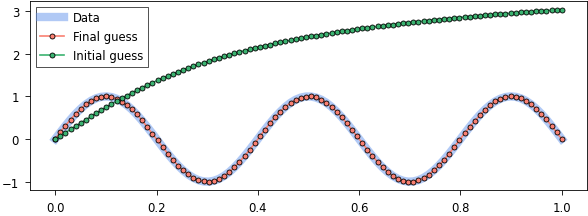

In [10]:
plt.plot(sol.t, data, "-", linewidth=5, alpha=0.5, label="Data")


sol = ivpsolve.solve_fixed_grid(
    vf, initial_values=(u0,), grid=grid, solver=solver, parameters=p
)
plt.plot(sol.t, sol.u, ".-", label="Final guess")

sol = ivpsolve.solve_fixed_grid(
    vf, initial_values=(u0,), grid=grid, solver=solver, parameters=f_args
)
plt.plot(sol.t, sol.u, ".-", label="Initial guess")


plt.legend()
plt.show()

## What's next


The same example can be constructed with deep learning libraries such as [Equinox](https://docs.kidger.site/equinox/), [Haiku](https://dm-haiku.readthedocs.io/en/latest/), or [Flax](https://flax.readthedocs.io/en/latest/getting_started.html).
To do so, define a corresponding vector field and a parameter set, build a new loss function and repeat.

